In [1]:
import spotipy
import pandas as pd
import numpy as np
from spotipy.oauth2 import SpotifyOAuth
import time

In [2]:
client_id='c4ff820f994745288df451ea7d6940d5'
client_secret='be2297719e5e4fb698f112c4374ee3b1'
redirect_uri='https://open.spotify.com/'
token_url = "https://accounts.spotify.com/api/token"

## Project Outline

- download a dataset of spotify playlists
- find or write a library to handle genre etc analysis
- group similar playlists
- use plotting techniques to show clusters?

Project Proposal:
I am personally interested in analyzing my longterm listening and curation history through Spotify and spotipy. I have an extensive collection of playlists, which due to their regularity, can be analyzed as objects. The intention of the analysis is to uncover trends in the groupings, visualize the relative distances (similarities) of songs within playlists, and create a prediction mechanism for most similar playlists. I will use sklearn, matplotlib, and seaborn for the clustering and visualizations.

## User Auth

In [102]:
scope = 'playlist-read-private'

sp_oauth = SpotifyOAuth(client_id=client_id,client_secret=client_secret,redirect_uri=redirect_uri,scope=scope)
token_info = sp_oauth.get_cached_token() 
if not token_info:
    auth_url = sp_oauth.get_authorize_url()
    print(auth_url)
    response = input('Paste the above link into your browser, then paste the redirect url here: ')

    code = sp_oauth.parse_response_code(response)
    token_info = sp_oauth.get_access_token(code)

    token = token_info['access_token']

sp = spotipy.Spotify(auth=token, retries=10, requests_timeout=10)

https://accounts.spotify.com/authorize?client_id=c4ff820f994745288df451ea7d6940d5&response_type=code&redirect_uri=https%3A%2F%2Fopen.spotify.com%2F&scope=playlist-read-private


/var/folders/dy/m7tb4mx52sv0lxfvtf95srbc0000gn/T/ipykernel_5389/4118829141.py:11: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token_info = sp_oauth.get_access_token(code)


In [5]:
# scope = 'playlist-read-private'

# oauth = spotipy.util.prompt_for_user_token(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope=scope)
# sp = spotipy.Spotify(auth=oauth)

In [6]:
if sp:
    print(sp.me())

{'display_name': 'amaya lim', 'external_urls': {'spotify': 'https://open.spotify.com/user/nightrainlily'}, 'href': 'https://api.spotify.com/v1/users/nightrainlily', 'id': 'nightrainlily', 'images': [{'url': 'https://i.scdn.co/image/ab67757000003b82180bd1d0c567a1e26710aeb8', 'height': 64, 'width': 64}, {'url': 'https://i.scdn.co/image/ab6775700000ee85180bd1d0c567a1e26710aeb8', 'height': 300, 'width': 300}], 'type': 'user', 'uri': 'spotify:user:nightrainlily', 'followers': {'href': None, 'total': 361}}


## Getting Playlists

In [11]:
from time import sleep
from tqdm import tqdm, trange

In [16]:
def get_all_playlists():
    playlist_count = 1000
    results = []
    offset = 0
    pbar = tqdm(total=1000)
    while offset < playlist_count:
        results.append(sp.current_user_playlists(limit=50, offset=offset))
        time.sleep(10)
        pbar.update(50)
        offset += 50
    pbar.close()
    return results
results = get_all_playlists()

KeyboardInterrupt: 

In [18]:
print(results)

[{'href': 'https://api.spotify.com/v1/users/nightrainlily/playlists?offset=0&limit=50', 'limit': 50, 'next': 'https://api.spotify.com/v1/users/nightrainlily/playlists?offset=50&limit=50', 'offset': 0, 'previous': None, 'total': 1083, 'items': [{'collaborative': False, 'description': '', 'external_urls': {'spotify': 'https://open.spotify.com/playlist/6OrcGRAMqQ3A6o2zCmqTj5'}, 'href': 'https://api.spotify.com/v1/playlists/6OrcGRAMqQ3A6o2zCmqTj5', 'id': '6OrcGRAMqQ3A6o2zCmqTj5', 'images': [{'height': None, 'url': 'https://i.scdn.co/image/ab67616d00001e02384d10f967c2b914de7e2713', 'width': None}], 'name': '842', 'owner': {'display_name': 'amaya lim', 'external_urls': {'spotify': 'https://open.spotify.com/user/nightrainlily'}, 'href': 'https://api.spotify.com/v1/users/nightrainlily', 'id': 'nightrainlily', 'type': 'user', 'uri': 'spotify:user:nightrainlily'}, 'primary_color': None, 'public': True, 'snapshot_id': 'AAAABEeCVuUIQ5XJyNKPsVpSPvGz1dCg', 'tracks': {'href': 'https://api.spotify.com

In [19]:
def parse(playlist_json, target):
    lst = []
    for i in np.arange(len(playlist_json['items'])):
        target_value = playlist_json['items'][i]['track'][target]
        lst.append(target_value)
    return lst 

In [20]:
import re

playlist_data = []

for result in results:
    # pbar = tqdm(total=1000)
    for playlist in result['items']:
        reg = "^([0-9])+\s([a-z]+(\s?)([a-z]?))"
        # pbar.update(1)
        if re.search(reg, playlist['name']) != None:
            track_info = sp.playlist_tracks(playlist['id'], fields='items(track(id, name))')
            playlist_data.append({
                'name' : playlist['name'],
                'track_ids' : parse(track_info, 'id'),
                'track_names' : parse(track_info, 'name'),
                'id' : playlist['id'],
                'image' : playlist['images'][0]['url']
            })
    # pbar.close()

playlists = pd.DataFrame(playlist_data)
# playlists.head().style.format({'image': lambda x : f'<img src="{x}" width="100px"/>'})
# playlists.head()




  2%|▏         | 18/1000 [04:47<4:21:09, 15.96s/it]




































































































































  5%|▌         | 50/1000 [00:10<03:17,  4.80it/s]

















































  5%|▌         | 50/1000 [00:10<03:20,  4.75it/s]

















































  5%|▌         | 50/1000 [00:11<03:42,  4.27it/s]


















































  5%|▌         | 50/1000 [00:12<03:54,  4.05it/s]


















































  5%|▌         | 50/1000 [00:10<03:18,  4.78it/s]

















































  5%|▌         | 50/1000 [00:11<03:31,  4.48it/s]


















































  5%|▌         | 50/1000 [00:11<03:40,  4.31it/s]

















































  5%|▌         | 50/1000 [00:10<03:16,  4.83it/s]


















































  5%|▌         | 

In [21]:
def pretty_tracks(col, name):
        all_l = []
        for i in np.arange(len(playlists[col])):
                row = playlists[col].values[i]
                l = []
                for j in row:
                        for k in np.arange(len(row)):
                                track = item[k]['track']
                                id = track[name]
                                l.append(id)
                all_l.append(l)
        return all_l

# playlists['track_ids'] = pretty_tracks('track_ids', 'id')
# playlists['track_names'] = pretty_tracks('track_names', 'name')

# playlists.head().style.format({'image': lambda x : f'<img src="{x}" width="100px"/>'})


## Getting Song Data

In [22]:
songs = playlists
songs['zipp'] = list(zip(songs['track_ids'], songs['track_names']))

In [23]:
def merge(z):
    return list(tuple(zip(z[0], z[1])))

songs['zipp'] = songs['zipp'].apply(merge)
songs.head()

,name,track_ids,track_names,id,image,zipp
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"[(0WbMK4wrZ1wFSty9F7FCgu, Good Luck, Babe!), (..."
1,840 pretty woman,"[35tWhD29yvWwB0IDRr6zsL, 5sMEEjviCkH6Rp5X2ZvII...","[Yeah Right, Everything is romantic, Frank's T...",6T6cMAfk5OTqGcs3L1gUUU,https://image-cdn-ak.spotifycdn.com/image/ab67...,"[(35tWhD29yvWwB0IDRr6zsL, Yeah Right), (5sMEEj..."
2,840 it falls apart,"[10cGyorRXoOc9RhVhY9Sru, 7hETG5A8HK2JIjnzUNhfK...","[She's Leaving You, Right Before the Last Wave...",2rARwXlp3rvRwTDnT6KXXu,https://mosaic.scdn.co/640/ab67616d00001e02012...,"[(10cGyorRXoOc9RhVhY9Sru, She's Leaving You), ..."
3,839 just friends,"[4LKYOetuIF5c9XjeLBL9av, 19RybK6XDbAVpcdxSbZL1...","[Naked In Manhattan, Apple, I Blame Myself, ch...",2taGVw80wRJx7DDCTnoYYN,https://image-cdn-ak.spotifycdn.com/image/ab67...,"[(4LKYOetuIF5c9XjeLBL9av, Naked In Manhattan),..."
4,838 ride for you,"[2YFhqZvhTpyK13gKXMKV7R, 14Ao5GwSPhlroo0EhAgtR...","[Girl, so confusing featuring lorde, Icing on ...",0ZQ1FLl4lOAYbxEc0BObpn,https://image-cdn-ak.spotifycdn.com/image/ab67...,"[(2YFhqZvhTpyK13gKXMKV7R, Girl, so confusing f..."


In [24]:
songs = songs.explode('zipp')
songs.head()

,name,track_ids,track_names,id,image,zipp
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0WbMK4wrZ1wFSty9F7FCgu, Good Luck, Babe!)"
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(7FwBtcecmlpc1sLySPXeGE, Dancing In the Dark)"
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(6SIooImkHGKCIwgUZ3WDvD, Hot & Heavy)"
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(12d4zdwjemoFecSGoobalx, The Morning Fog - 201..."
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1fDFHXcykq4iw8Gg7s5hG9, About You)"


In [25]:
songs['track_name'] = songs['zipp'].map(lambda x: x[1])
songs['track_id'] = songs['zipp'].map(lambda x: x[0])
songs.head()

,name,track_ids,track_names,id,image,zipp,track_name,track_id
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0WbMK4wrZ1wFSty9F7FCgu, Good Luck, Babe!)","Good Luck, Babe!",0WbMK4wrZ1wFSty9F7FCgu
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(7FwBtcecmlpc1sLySPXeGE, Dancing In the Dark)",Dancing In the Dark,7FwBtcecmlpc1sLySPXeGE
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(6SIooImkHGKCIwgUZ3WDvD, Hot & Heavy)",Hot & Heavy,6SIooImkHGKCIwgUZ3WDvD
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(12d4zdwjemoFecSGoobalx, The Morning Fog - 201...",The Morning Fog - 2018 Remaster,12d4zdwjemoFecSGoobalx
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1fDFHXcykq4iw8Gg7s5hG9, About You)",About You,1fDFHXcykq4iw8Gg7s5hG9


In [26]:
songs.reset_index()

,index,name,track_ids,track_names,id,image,zipp,track_name,track_id
0,0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0WbMK4wrZ1wFSty9F7FCgu, Good Luck, Babe!)","Good Luck, Babe!",0WbMK4wrZ1wFSty9F7FCgu
1,0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(7FwBtcecmlpc1sLySPXeGE, Dancing In the Dark)",Dancing In the Dark,7FwBtcecmlpc1sLySPXeGE
2,0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(6SIooImkHGKCIwgUZ3WDvD, Hot & Heavy)",Hot & Heavy,6SIooImkHGKCIwgUZ3WDvD
3,0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(12d4zdwjemoFecSGoobalx, The Morning Fog - 201...",The Morning Fog - 2018 Remaster,12d4zdwjemoFecSGoobalx
4,0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(1fDFHXcykq4iw8Gg7s5hG9, About You)",About You,1fDFHXcykq4iw8Gg7s5hG9
...,...,...,...,...,...,...,...,...,...
9688,924,006 outside in // my way,"[64P3zpRsDHIk7YTpRtaKYL, 0gCJkpD0RhF2rjiALLHBQ...",[Everybody's Got Something To Hide Except Me A...,5eFI6gvsz2VKkHbXxzvx90,https://mosaic.scdn.co/640/ab67616d00001e0206e...,"(51Y1WwassIhqZYBwwaAjzr, Mellow)",Mellow,51Y1WwassIhqZYBwwaAjzr
9689,924,006 outside in // my way,"[64P3zpRsDHIk7YTpRtaKYL, 0gCJkpD0RhF2rjiALLHBQ...",[Everybody's Got Something To Hide Except Me A...,5eFI6gvsz2VKkHbXxzvx90,https://mosaic.scdn.co/640/ab67616d00001e0206e...,"(2zLIjfjQ8kMy7WSSLmF0I2, Thank You - 2008 Rema...",Thank You - 2008 Remaster,2zLIjfjQ8kMy7WSSLmF0I2
9690,924,006 outside in // my way,"[64P3zpRsDHIk7YTpRtaKYL, 0gCJkpD0RhF2rjiALLHBQ...",[Everybody's Got Something To Hide Except Me A...,5eFI6gvsz2VKkHbXxzvx90,https://mosaic.scdn.co/640/ab67616d00001e0206e...,"(1ksayCHVLH4eKFm43GFokU, Baby, I Love Your Way...","Baby, I Love Your Way - Live",1ksayCHVLH4eKFm43GFokU
9691,924,006 outside in // my way,"[64P3zpRsDHIk7YTpRtaKYL, 0gCJkpD0RhF2rjiALLHBQ...",[Everybody's Got Something To Hide Except Me A...,5eFI6gvsz2VKkHbXxzvx90,https://mosaic.scdn.co/640/ab67616d00001e0206e...,"(2gFXQQ7dDY4lquHpUNeDTM, Debris)",Debris,2gFXQQ7dDY4lquHpUNeDTM


### Audio Features

In [95]:
test = songs.head(1000)

In [100]:
def batch(lst, n):
    for i in range(0, len(lst), n):
        if len(lst) >= (i+n):
            yield lst[i:i + n]
        else:
            yield lst[i:]

def get_audio_features(uris):
    results = []
    pbar = tqdm(total=1000)
    batched = batch(uris, 100)
    for each in batched:
        results.append(sp.audio_features(each))
        time.sleep(10)
        pbar.update(50)
    pbar.close()
    return results

In [103]:
audio_features_results = get_audio_features(songs['track_id'])
audio_features_results.head()

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=3SYNTZgVt7Wht3jRf0ElGh,6ugo6TrO93ZW9gAovTzegl,79xgVUXA77Sz3S5WWvfQX3,6t3RJKJh8DYIaYh82Xy2LJ,7tZYfnIYbcno0cngy9f0PG,459Resbyur6taSgF578fVb,6dOtVTDdiauQNBQEDOtlAB,6Y2bJ2mjDB2zXmVBtVqdXf,3UY4s7F4Ard3T6vm7xcJxQ,3J09NCAVxby84HQxp8C0dO,2uHWrdFnsvWZoVt0it6de2,6OS3VD7oJgqhEKTEkkRB94,36vmaZyO0iAE6FZ7287fg2,1awQLv1J6LkeEQ5co4OOoQ,2Nq4SFbvYYZa8AF7lD7CWU,5H6zfiMskqiwhbiKRRHE7F,0qAEulekaDyi3fR6S1gOaX,6adP4Nm71rKd9TKeRIMYZw,1vtytjTaju3xjXTXqnHJWc,5U0vVExqpq4pOEhs2ODuA9,49MS1LeGxzcG9LOvpzhAQr,0WH39BFVGotzXe3torfzvK,1SfRtvvMlxZ7Zwi0dnnqYO,19UqVT2WgSz39uvT28mCHg,6cmVYmv9o8OTzI9FXuNqSp,4Wo3ZATquIN6z4Zr1W4749,629DixmZGHc7ILtEntuiWE,7lw4J2RfcPs2hEJgPY44lC,5Q6OXP4UlS1stbtGfBLZ9I,06wlFUDDfck4732GJz6LvZ,3GREjwadOvBZW448ULa6TC,6Bw0jy3ITayT8mdAYKmQCc,1Ad2HcIX9zBqoWRvxtpYGf,0Cn4UhpHhgf88eWaS9nn5u,2D3oVAd8nHrqJH8UAfvtTT,0UMfconu33lpuioJ696nKv,460fiLttrlcZYSfc7c7Uus,1iYfBjjf08Wdw6KPfWf7Ox,106CGBxxQ0ncAAupiBUNqf,4w1esviQOM4f8uZ6RuAjyY,1qPDHJnx0JuDOE7QnpjtAd,2J0fVhnr4NL4GsQbxmeupH,2tURHGj7a7sWyosRk4c1VX,7LTNjzQRoE0LMGyzymXTpU,1AT7v7BrLfBbjQwzsl79Qm,2aULK5mtJaeb4KF0xnAuyU,5HeivWMgipA2LeBHrUhEip,63I9ZUyAjWxkY44Gyj5KCO,7sWKIQsoW2dlKMNobxXoXp,5zxqk9zM1cQ0PFz0fB031o,6pWTU0aT17HmXElXLdlI49,4wHo9RDSY0elxbeiMpYNLN,4JgOwWUIO9myLqiOOW7IIg,5PurHGjwfAQel15O4ZIiGu,5aaj6sbn0wh5ASP9aZ6EtC,6rCQnAXP0UKEGKPZF8u5iL,0TVMOi7iwDYpgJexAlNtm9,3l3T6ZyuuqeUT3mcLGjW4V,23uLia0r9XqAIKrj0Rlc4D,6XTcGuOMdhoG1kjoqVw8iM,6GUv3PAHoR1IVoonUmiSFi,0XHFylA18yuwGVCfJfq4dw,6hnrIg9WUBJQX0BACojEog,5MXegzzvDfUSfwpf8a0FCq,5TLMnMcFTlxa7on9ZltYzz,0NlYeYreqeP6OO5cYG2ALx,2wxUkiCXqB5BxGOQp0JjZa,4QtzCm1dFD3p14kPJpkb9U,13bYIuh0mNfCh5UW8vGrg5,5qcwzdhDQjHjmu12gOLjY0,0zikWa6k06uycAkRB8CsXA,4x3sybEOR5osaruxUNMd3e,2Wcb3br32OWqdDiJwUzl9i,1b3pE4kVSeq89zVJSXUz1u,2mqSzhWWZePP0un56ikszA,4cuj3hgXjsSgvCuwFWNuKJ,7JxexWxny7yJ3slTLmWz2U,0ccoGCaOFCxI6pHixrQpKj,5Z8Dj3LtbyCMiwE86rhg2f,1Ar2McJ98hNvgsHlxLTPQc,3CqaTHbiU2nBy3Ar9RnDHN,5I73WkfhuOvavHVYk3TGrm,3BI3yIp1aa5yzMNpyTmNyX,57HNTVH3qpDVOGEzFB1dda,3360fzHkXtFCGSnTpyBMRA,3Wfxy69tnwong1WWXOEjyW,0JJoCLo8PKzHpdDLKcSq1v,5MQTgrkH8luhQt5Uncvhhz,5lmLmGcxdwlEAGf1uogoO4,5quMyURZK060qsvhuyXvQ9,2UKg3j9nB51RJ5nTPw1S8U,43HCOk3H6xLIPDfGQjAcVj,7soqmGSW7TdgyYKs2P2KIJ,48HHmBGOItVHmuFbTx7csG,1Dx3VdEllKOXDshSN19AxV,1Bk53icdNPgGKJMINHMw1Z,74NvPuNmUzeXog7Dl3kN1L,0wSQyNqdv75aNGfmXQ3Q9F,4gMUmiLng8cPWB55zE33QP,4AvKo0vzRF4Kf3TqYdefbK:
 Max Retries, reason: too many 429 error responses

In [45]:
features_db = pd.DataFrame([result[0] for result in audio_features_results])
features_db.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.700,0.582,11,-5.960,0,0.0356,0.0502,0.000000,0.0881,0.785,116.712,audio_features,0WbMK4wrZ1wFSty9F7FCgu,spotify:track:0WbMK4wrZ1wFSty9F7FCgu,https://api.spotify.com/v1/tracks/0WbMK4wrZ1wF...,https://api.spotify.com/v1/audio-analysis/0WbM...,218424,4
1,0.527,0.942,1,-5.640,0,0.0366,0.0115,0.000000,0.1880,0.495,148.723,audio_features,7FwBtcecmlpc1sLySPXeGE,spotify:track:7FwBtcecmlpc1sLySPXeGE,https://api.spotify.com/v1/tracks/7FwBtcecmlpc...,https://api.spotify.com/v1/audio-analysis/7FwB...,241307,4
2,0.551,0.780,0,-6.659,1,0.0550,0.0941,0.000001,0.1100,0.421,135.023,audio_features,6SIooImkHGKCIwgUZ3WDvD,spotify:track:6SIooImkHGKCIwgUZ3WDvD,https://api.spotify.com/v1/tracks/6SIooImkHGKC...,https://api.spotify.com/v1/audio-analysis/6SIo...,250613,4
3,0.702,0.381,4,-12.842,1,0.0300,0.6480,0.000238,0.0960,0.798,129.345,audio_features,12d4zdwjemoFecSGoobalx,spotify:track:12d4zdwjemoFecSGoobalx,https://api.spotify.com/v1/tracks/12d4zdwjemoF...,https://api.spotify.com/v1/audio-analysis/12d4...,155720,4
4,0.416,0.762,2,-7.385,1,0.0279,0.3120,0.804000,0.0559,0.461,95.967,audio_features,1fDFHXcykq4iw8Gg7s5hG9,spotify:track:1fDFHXcykq4iw8Gg7s5hG9,https://api.spotify.com/v1/tracks/1fDFHXcykq4i...,https://api.spotify.com/v1/audio-analysis/1fDF...,326491,4


In [46]:
features = test.merge(features_db,  left_on='track_id', right_on='id')
features.head()

,name,track_ids,track_names,id_x,image,zipp,track_name,track_id,danceability,energy,...,liveness,valence,tempo,type,id_y,uri,track_href,analysis_url,duration_ms,time_signature
0,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0WbMK4wrZ1wFSty9F7FCgu, Good Luck, Babe!)","Good Luck, Babe!",0WbMK4wrZ1wFSty9F7FCgu,0.700,0.582,...,0.0881,0.785,116.712,audio_features,0WbMK4wrZ1wFSty9F7FCgu,spotify:track:0WbMK4wrZ1wFSty9F7FCgu,https://api.spotify.com/v1/tracks/0WbMK4wrZ1wF...,https://api.spotify.com/v1/audio-analysis/0WbM...,218424,4
1,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(0WbMK4wrZ1wFSty9F7FCgu, Good Luck, Babe!)","Good Luck, Babe!",0WbMK4wrZ1wFSty9F7FCgu,0.700,0.582,...,0.0881,0.785,116.712,audio_features,0WbMK4wrZ1wFSty9F7FCgu,spotify:track:0WbMK4wrZ1wFSty9F7FCgu,https://api.spotify.com/v1/tracks/0WbMK4wrZ1wF...,https://api.spotify.com/v1/audio-analysis/0WbM...,218424,4
2,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(7FwBtcecmlpc1sLySPXeGE, Dancing In the Dark)",Dancing In the Dark,7FwBtcecmlpc1sLySPXeGE,0.527,0.942,...,0.1880,0.495,148.723,audio_features,7FwBtcecmlpc1sLySPXeGE,spotify:track:7FwBtcecmlpc1sLySPXeGE,https://api.spotify.com/v1/tracks/7FwBtcecmlpc...,https://api.spotify.com/v1/audio-analysis/7FwB...,241307,4
3,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(6SIooImkHGKCIwgUZ3WDvD, Hot & Heavy)",Hot & Heavy,6SIooImkHGKCIwgUZ3WDvD,0.551,0.780,...,0.1100,0.421,135.023,audio_features,6SIooImkHGKCIwgUZ3WDvD,spotify:track:6SIooImkHGKCIwgUZ3WDvD,https://api.spotify.com/v1/tracks/6SIooImkHGKC...,https://api.spotify.com/v1/audio-analysis/6SIo...,250613,4
4,00 call it love,"[0WbMK4wrZ1wFSty9F7FCgu, 7FwBtcecmlpc1sLySPXeG...","[Good Luck, Babe!, Dancing In the Dark, Hot & ...",0cYsC9QCNUvlvz2shindLS,https://image-cdn-ak.spotifycdn.com/image/ab67...,"(12d4zdwjemoFecSGoobalx, The Morning Fog - 201...",The Morning Fog - 2018 Remaster,12d4zdwjemoFecSGoobalx,0.702,0.381,...,0.0960,0.798,129.345,audio_features,12d4zdwjemoFecSGoobalx,spotify:track:12d4zdwjemoFecSGoobalx,https://api.spotify.com/v1/tracks/12d4zdwjemoF...,https://api.spotify.com/v1/audio-analysis/12d4...,155720,4


In [47]:
playlist_features = features[['name', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].groupby('name').mean().reset_index()
playlist_features.head()

,name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,00 call it love,0.589182,0.677182,3.363636,-8.255636,0.636364,0.054555,0.175455,0.078579,0.121173,0.635273,120.772818
1,794 can’t do without,0.617556,0.710333,4.444444,-6.268667,0.777778,0.067044,0.086754,0.007326,0.151633,0.656667,114.327222
2,795 change me,0.553000,0.469091,6.181818,-10.595455,0.818182,0.033745,0.417036,0.313746,0.145036,0.431800,118.623727
3,796 let me know,0.524300,0.529100,4.300000,-8.709400,0.600000,0.045700,0.458380,0.082026,0.223400,0.432250,129.493300
4,797 the way you look at me,0.511100,0.299670,5.200000,-12.661100,0.900000,0.037230,0.703300,0.060690,0.152770,0.322400,114.448900


In [ ]:
# clustering
# k mediods
# silhouette coefficient plotting
# visualization
# input-output mechanism

### PCA

In [51]:
from sklearn.decomposition import PCA

In [76]:
X = playlist_features.set_index('name')

pca = PCA(n_components=3)

pc = pd.DataFrame(pca.fit_transform(X))
pc.head()

,0,1,2
0,2.258414,0.248283,-1.686633
1,-4.075067,2.591957,-0.674732
2,0.136490,-1.658908,1.483419
3,10.984798,-0.446098,-0.977605
4,-4.139751,-3.699424,0.914575


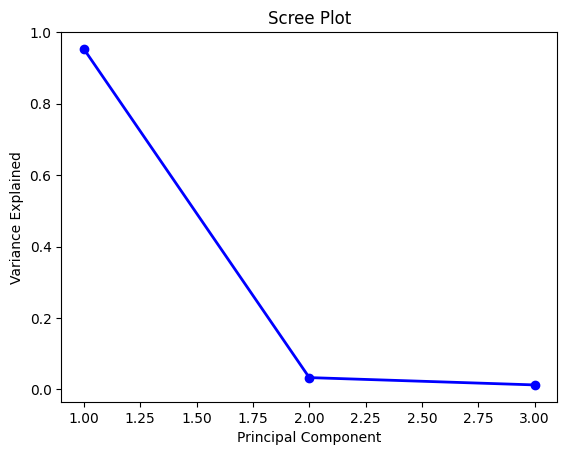

In [77]:
import matplotlib.pyplot as plt

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [78]:
pc['name'] = playlist_features['name']
pc.columns = ['pc1', 'pc2', 'pc3', 'name']
pc.head()

,pc1,pc2,pc3,name
0,2.258414,0.248283,-1.686633,00 call it love
1,-4.075067,2.591957,-0.674732,794 can’t do without
2,0.136490,-1.658908,1.483419,795 change me
3,10.984798,-0.446098,-0.977605,796 let me know
4,-4.139751,-3.699424,0.914575,797 the way you look at me


### Clustering

In [ ]:
from sklearn_extra.cluster import KMedoids as kmedoids
from sklearn.metrics import silhouette_score

In [148]:
# cluster_X = pd.concat([X, pc], axis=1, join='inner')

X = playlist_features.drop(['key', 'mode'], axis=1).set_index('name')

In [149]:
s_scores = []

num_clusters = 1
low_score = -1
for i in range(2, 30):
    s = silhouette_score(X, kmedoids(n_clusters=i, random_state=42).fit_predict(X))
    s_scores.append(s)
    if s > low_score:
        low_score = s
        num_clusters = i

print(num_clusters)

2


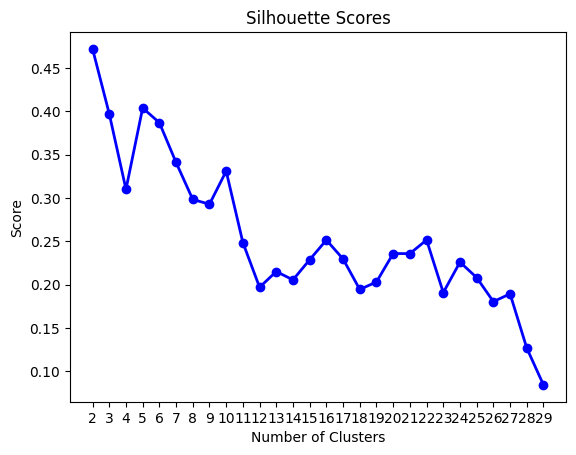

In [150]:
plt.plot(range(2, 30), s_scores, 'o-', linewidth=2, color='blue')
plt.xticks(range(2, 30))
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [152]:
km = kmedoids(n_clusters=5)
clusters = km.fit_predict(X)

X['cluster'] = clusters

In [153]:
X.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
name,,,,,,,,,,
00 call it love,0.589182,0.677182,-8.255636,0.054555,0.175455,0.078579,0.121173,0.635273,120.772818,0
794 can’t do without,0.617556,0.710333,-6.268667,0.067044,0.086754,0.007326,0.151633,0.656667,114.327222,4
795 change me,0.553000,0.469091,-10.595455,0.033745,0.417036,0.313746,0.145036,0.431800,118.623727,3
796 let me know,0.524300,0.529100,-8.709400,0.045700,0.458380,0.082026,0.223400,0.432250,129.493300,1
797 the way you look at me,0.511100,0.299670,-12.661100,0.037230,0.703300,0.060690,0.152770,0.322400,114.448900,3


In [154]:
cluster0 = X.loc[X['cluster'] == 0]
cluster0.index

Index(['00 call it love', '799 deserve', '806 love me for nothing',
       '813 wait for your love', '814 shift shapes', '818 switch it up',
       '822 classical virtue', '834 heartbreak', '836 coming around',
       '838 ride for you', '839 just friends'],
      dtype='object', name='name')

### Visualization

In [122]:
import seaborn as sns

<Axes: xlabel='energy', ylabel='danceability'>

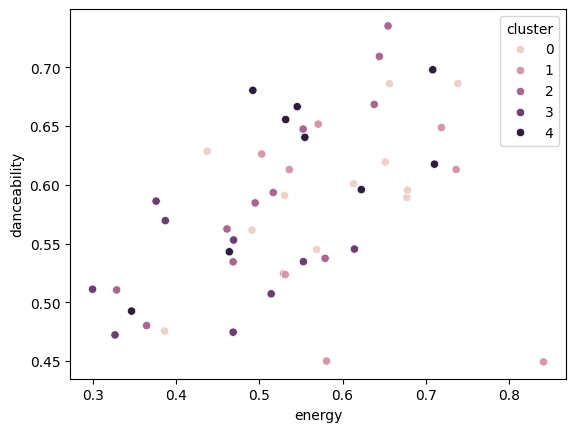

In [156]:
sns.scatterplot(X, x='energy', y='danceability', hue='cluster')

### Recommendation System